# **Data Reduction:**
Here as we need more feutures with predictive model , we combine some of veh cols into acc

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
import time
import missingno as msno
import matplotlib.dates as mdates
import pickle
import datetime


from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.ensemble import BalancedRandomForestClassifier

from google.colab import drive
drive.mount('/content/drive')
!ls /content/drive/MyDrive/Accidents/Data
!ls "/content/drive/My Drive/Colab Notebooks/Data/"
Data_Folder_Name="/content/drive/My Drive/Accidents/Data/"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
acc_cat.pkl
acc_enc.pkl
acc_rf.pkl
dft-road-casualty-statistics-accident-1979-2021.csv
dft-road-casualty-statistics-casualty-1979-2021.csv
dft-road-casualty-statistics-vehicle-1979-2021.csv
dft-road-casualty-statistics-vehicle-2020.csv
dft-road-casualty-statistics-vehicle-2021.csv
rf_best_071603.pkl
rf_best_071711.pkl
rf_best_071720.pkl
rf_best_071723.pkl
Road-Safety-Open-Dataset-Data-Guide.xlsx
dft-road-casualty-statistics-accident-2020.csv
dft-road-casualty-statistics-casualty-2020.csv
dft-road-casualty-statistics-vehicle-2020.csv
Road-Safety-Open-Dataset-Data-Guide.xlsx


In [2]:
ACC_PATH_ALL =Data_Folder_Name+'dft-road-casualty-statistics-accident-1979-2021.csv'
print(ACC_PATH_ALL)
acc_df = (pd.read_csv(ACC_PATH_ALL, parse_dates=["date"],dtype={'accident_index': str})[lambda x: x['accident_year'] > 2018])

acc_df.replace(-1, np.nan, inplace=True)
acc_df.drop(columns=['location_easting_osgr', 'location_northing_osgr','second_road_class', 'second_road_number', 'junction_control','local_authority_district'],inplace=True)
acc_df.info()

/content/drive/My Drive/Accidents/Data/dft-road-casualty-statistics-accident-1979-2021.csv


<ipython-input-2-b420735857ed>:3: DtypeWarning: Columns (2,15,16,35) have mixed types. Specify dtype option on import or set low_memory=False.
  acc_df = (pd.read_csv(ACC_PATH_ALL, parse_dates=["date"],dtype={'accident_index': str})[lambda x: x['accident_year'] > 2018])
<ipython-input-2-b420735857ed>:3: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  acc_df = (pd.read_csv(ACC_PATH_ALL, parse_dates=["date"],dtype={'accident_index': str})[lambda x: x['accident_year'] > 2018])


<class 'pandas.core.frame.DataFrame'>
Int64Index: 309822 entries, 8394089 to 8703910
Data columns (total 30 columns):
 #   Column                                       Non-Null Count   Dtype         
---  ------                                       --------------   -----         
 0   accident_index                               309822 non-null  object        
 1   accident_year                                309822 non-null  int64         
 2   accident_reference                           309822 non-null  object        
 3   longitude                                    309763 non-null  float64       
 4   latitude                                     309763 non-null  float64       
 5   police_force                                 309822 non-null  int64         
 6   accident_severity                            309822 non-null  int64         
 7   number_of_vehicles                           309822 non-null  int64         
 8   number_of_casualties                         309822 non-n

In [3]:
acc_df['trunk_road_flag'].fillna(3,inplace=True) # a new value this is for outside england
acc_df['road_surface_conditions'].fillna(9,inplace=True) # 9 is selfreport
acc_df.dropna(axis=0,inplace=True) ## remove few instances for which we miss some values

intcols=['speed_limit','junction_detail','pedestrian_crossing_human_control','pedestrian_crossing_physical_facilities', 'light_conditions','weather_conditions',
         'road_surface_conditions','special_conditions_at_site', 'carriageway_hazards','did_police_officer_attend_scene_of_accident','trunk_road_flag']
acc_df[intcols]=acc_df[intcols].astype('int')

acc_df["date"] = pd.to_datetime(acc_df["date"], format="%d/%m/%Y")
acc_df["hour"] = acc_df.time.str[0:2]
acc_df['hour'] = acc_df['hour'].astype('int')  # it has some old nan

#new_weekend column
acc_df['weekend'] = np.where(acc_df['day_of_week'].isin([1,7]), 1, 0)   # 1 is Sunday , 7 is Saturday
#new month column
acc_df['month'] = acc_df ['date'].apply(lambda time: time.month)
## could change this to lambda
acc_df['covid']=((acc_df['date']> '2020-02-28')&(acc_df['date']< '2021-03-29')).astype(int)

acc_df['accident_level'] = np.where(acc_df['accident_severity']==3, 0, 1)  # Binary target value

timeofdaygroups = {1: "Morning Rush (6-10)",
                   2: "Noon (10-14)",
                   3: "Evening Rush (14-19)",
                   4: "Night (19-6)"}
def daygroup(hour):
    if hour >= 6 and hour < 10:
        return 1
    elif hour >= 10 and hour < 14:
        return 2
    elif hour >= 14 and hour < 19:
        return 3
    else:
        return 4
acc_df['time_of_day'] = acc_df['hour'].apply(daygroup)


d64 = dict.fromkeys(acc_df.select_dtypes(np.int64).columns, np.int32)
acc_df = acc_df.astype(d64)


acc_df.loc[acc_df['did_police_officer_attend_scene_of_accident'] >=2 , 'did_police_officer_attend_scene_of_accident'] = 0     #yes 1 no 0
acc_df.loc[acc_df['urban_or_rural_area'] >=2 , 'did_police_officer_attend_scene_of_accident'] = 0     #Urban 1 Rural 0

acc_df.loc[acc_df['number_of_vehicles'] > 4, 'number_of_vehicles'] = 5
acc_df.loc[acc_df['number_of_casualties'] > 4, 'number_of_casualties'] = 5

# extra time and location columns
TLcols=['date','time','local_authority_ons_district','local_authority_highway','lsoa_of_accident_location','first_road_number']
acc_df.drop(columns=TLcols,inplace=True)

#Categorical:     binary columns
binarycol=['covid','weekend','urban_or_rural_area','accident_level','did_police_officer_attend_scene_of_accident']
acc_df[binarycol] = acc_df[binarycol].astype('uint8')

acc_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 308586 entries, 8394089 to 8703910
Data columns (total 30 columns):
 #   Column                                       Non-Null Count   Dtype  
---  ------                                       --------------   -----  
 0   accident_index                               308586 non-null  object 
 1   accident_year                                308586 non-null  int32  
 2   accident_reference                           308586 non-null  object 
 3   longitude                                    308586 non-null  float64
 4   latitude                                     308586 non-null  float64
 5   police_force                                 308586 non-null  int32  
 6   accident_severity                            308586 non-null  int32  
 7   number_of_vehicles                           308586 non-null  int32  
 8   number_of_casualties                         308586 non-null  int32  
 9   day_of_week                                  308586 

In [4]:
timeofdaygroups = {1: "Morning Rush (6-10)",
                   2: "Noon (10-14)",
                   3: "Evening Rush (14-19)",
                   4: "Night (19-6)"}
def daygroup(hour):
    if hour >= 6 and hour < 10:
        return 1
    elif hour >= 10 and hour < 14:
        return 2
    elif hour >= 14 and hour < 19:
        return 3
    else:
        return 4
acc_df['time_of_day'] = acc_df['hour'].apply(daygroup)
acc_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 308586 entries, 8394089 to 8703910
Data columns (total 30 columns):
 #   Column                                       Non-Null Count   Dtype  
---  ------                                       --------------   -----  
 0   accident_index                               308586 non-null  object 
 1   accident_year                                308586 non-null  int32  
 2   accident_reference                           308586 non-null  object 
 3   longitude                                    308586 non-null  float64
 4   latitude                                     308586 non-null  float64
 5   police_force                                 308586 non-null  int32  
 6   accident_severity                            308586 non-null  int32  
 7   number_of_vehicles                           308586 non-null  int32  
 8   number_of_casualties                         308586 non-null  int32  
 9   day_of_week                                  308586 

In [5]:
#make a small test set on weekends of last month of 2021
AdfT=acc_df[(acc_df.accident_year==2021) & (acc_df.month==12) & (acc_df.weekend==1)][['accident_index','accident_reference','police_force','accident_severity','number_of_vehicles','number_of_casualties'
      ,'speed_limit','junction_detail','urban_or_rural_area','carriageway_hazards','special_conditions_at_site']]
AdfT.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1530 entries, 8611721 to 8703867
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   accident_index              1530 non-null   object
 1   accident_reference          1530 non-null   object
 2   police_force                1530 non-null   int32 
 3   accident_severity           1530 non-null   int32 
 4   number_of_vehicles          1530 non-null   int32 
 5   number_of_casualties        1530 non-null   int32 
 6   speed_limit                 1530 non-null   int32 
 7   junction_detail             1530 non-null   int32 
 8   urban_or_rural_area         1530 non-null   uint8 
 9   carriageway_hazards         1530 non-null   int32 
 10  special_conditions_at_site  1530 non-null   int32 
dtypes: int32(8), object(2), uint8(1)
memory usage: 85.2+ KB


## **Vehicle** **DataFrame**

In [7]:
!ls /content/drive/MyDrive/Accidents/Data

acc_cat.pkl
acc_enc.pkl
acc_rf.pkl
dft-road-casualty-statistics-accident-1979-2021.csv
dft-road-casualty-statistics-casualty-1979-2021.csv
dft-road-casualty-statistics-vehicle-1979-2021.csv
dft-road-casualty-statistics-vehicle-2020.csv
dft-road-casualty-statistics-vehicle-2021.csv
rf_best_071603.pkl
rf_best_071711.pkl
rf_best_071720.pkl
rf_best_071723.pkl
Road-Safety-Open-Dataset-Data-Guide.xlsx


In [8]:
Data_Folder_Name="/content/drive/MyDrive/Accidents/Data/"
VEH_PATH_ALL =Data_Folder_Name+'dft-road-casualty-statistics-vehicle-1979-2021.csv'
print(VEH_PATH_ALL)

# Define the condition to filter rows
condition = lambda x: x['accident_year'] > 2018

# Read the data in chunks that satisfy the condition
chunksize = 200000  # Adjust the chunk size as per your memory capacity
filtered_chunks = []
for chunk in pd.read_csv(VEH_PATH_ALL, chunksize=chunksize,dtype={'accident_index': str},low_memory=False):
    filtered_chunk = chunk[condition(chunk)]
    filtered_chunks.append(filtered_chunk)

# Concatenate the filtered chunks into a single DataFrame
veh_df = pd.concat(filtered_chunks, ignore_index=True)

veh_df.info()

/content/drive/MyDrive/Accidents/Data/dft-road-casualty-statistics-vehicle-1979-2021.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 570199 entries, 0 to 570198
Data columns (total 28 columns):
 #   Column                            Non-Null Count   Dtype 
---  ------                            --------------   ----- 
 0   accident_index                    570199 non-null  object
 1   accident_year                     570199 non-null  int64 
 2   accident_reference                570199 non-null  object
 3   vehicle_reference                 570199 non-null  int64 
 4   vehicle_type                      570199 non-null  int64 
 5   towing_and_articulation           570199 non-null  int64 
 6   vehicle_manoeuvre                 570199 non-null  int64 
 7   vehicle_direction_from            570199 non-null  int64 
 8   vehicle_direction_to              570199 non-null  int64 
 9   vehicle_location_restricted_lane  570199 non-null  int64 
 10  junction_location                 57019

In [9]:
veh_df

,accident_index,accident_year,accident_reference,vehicle_reference,vehicle_type,towing_and_articulation,vehicle_manoeuvre,vehicle_direction_from,vehicle_direction_to,vehicle_location_restricted_lane,...,sex_of_driver,age_of_driver,age_band_of_driver,engine_capacity_cc,propulsion_code,age_of_vehicle,generic_make_model,driver_imd_decile,driver_home_area_type,lsoa_of_driver
0,2019010128300,2019,010128300,1,9,0,99,9,9,99,...,1,58,9,-1,-1,-1,-1,2,1,-1
1,2019010128300,2019,010128300,2,9,0,99,9,9,99,...,3,-1,-1,-1,-1,-1,-1,2,1,-1
2,2019010152270,2019,010152270,1,9,0,18,9,9,99,...,2,24,5,-1,-1,-1,-1,3,1,-1
3,2019010152270,2019,010152270,2,9,0,18,9,9,99,...,3,-1,-1,-1,-1,-1,-1,6,1,-1
4,2019010155191,2019,010155191,1,9,0,3,5,1,0,...,1,45,7,-1,-1,-1,-1,4,1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
570194,2021991196607,2021,991196607,2,9,0,18,1,5,0,...,1,61,9,-1,-1,-1,-1,9,2,-1
570195,2021991197944,2021,991197944,1,9,0,18,3,7,0,...,2,51,8,-1,-1,-1,-1,5,3,-1
570196,2021991200639,2021,991200639,1,9,0,18,4,8,0,...,2,24,5,-1,-1,-1,-1,4,1,-1
570197,2021991201030,2021,991201030,1,9,0,18,2,6,0,...,1,28,6,-1,-1,-1,-1,5,2,-1


In [10]:

#Data_Folder_Name="/content/drive/MyDrive/Accidents/Data/"
#vehfile2021=Data_Folder_Name+ 'dft-road-casualty-statistics-vehicle-2021.csv'
#print(VEH_PATH_ALL,vehfile2021)
#veh_df = (pd.read_csv(vehfile2021)[lambda x: x['accident_year'] > 2018])
#veh_df.info()

In [11]:
(veh_df == -1).sum().sort_values(ascending=False)


engine_capacity_cc                  162760
age_of_vehicle                      160649
propulsion_code                     160440
driver_imd_decile                   109658
driver_home_area_type               108843
age_band_of_driver                   79194
age_of_driver                        79194
generic_make_model                   37927
vehicle_direction_to                  6577
vehicle_direction_from                6219
first_point_of_impact                 3456
skidding_and_overturning              2662
vehicle_leaving_carriageway           2615
vehicle_manoeuvre                     2610
hit_object_in_carriageway             2557
vehicle_location_restricted_lane      2513
towing_and_articulation               2406
vehicle_left_hand_drive               1099
junction_location                     1056
hit_object_off_carriageway             352
vehicle_type                           310
journey_purpose_of_driver              245
sex_of_driver                           16
accident_in

In [12]:
# These Are the Columns that won't be helpful for the join with acc_df
dropcols=['accident_year','accident_reference','vehicle_direction_from','vehicle_direction_to','age_of_driver',
       'journey_purpose_of_driver','first_point_of_impact','vehicle_left_hand_drive', 'vehicle_manoeuvre',               ###not easy to assess with the satellite image for using in a model till afterward
       'age_band_of_driver', 'engine_capacity_cc', 'propulsion_code',
       'age_of_vehicle', 'driver_imd_decile',
       'driver_home_area_type', 'lsoa_of_driver']
veh_df.drop(columns=dropcols,inplace=True)

## columns not for Ml but good to comeback to it for analysis of which brands are the most cause for accidents
veh_df.drop(columns='generic_make_model',inplace=True)

print((veh_df == -1).sum().sort_values(ascending=False))
veh_df.info()


skidding_and_overturning            2662
vehicle_leaving_carriageway         2615
hit_object_in_carriageway           2557
vehicle_location_restricted_lane    2513
towing_and_articulation             2406
junction_location                   1056
hit_object_off_carriageway           352
vehicle_type                         310
sex_of_driver                         16
accident_index                         0
vehicle_reference                      0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 570199 entries, 0 to 570198
Data columns (total 11 columns):
 #   Column                            Non-Null Count   Dtype 
---  ------                            --------------   ----- 
 0   accident_index                    570199 non-null  object
 1   vehicle_reference                 570199 non-null  int64 
 2   vehicle_type                      570199 non-null  int64 
 3   towing_and_articulation           570199 non-null  int64 
 4   vehicle_location_restricted_lane  570199 n

In [13]:
#retreiving the label for each category of a feature
#From Data Guide

Data_Folder_Name="/content/drive/MyDrive/Accidents/Data/"
DG_PATH =Data_Folder_Name+'Road-Safety-Open-Dataset-Data-Guide.xlsx'
DG = pd.read_excel(DG_PATH)   # Data Guide dataframe
DG.iloc[[11,71,1198,1128,1248,1331,1348,1500],:]

,table,field name,code/format,label,note
11,Accident,police_force,6,Greater Manchester,NaN
71,Accident,day_of_week,7,Saturday,NaN
1198,Accident,road_surface_conditions,4,Frost or ice,NaN
1128,Accident,road_type,2,One way street,NaN
1248,Vehicle,vehicle_type,11,Bus or coach (17 or more pass seats),NaN
1331,Vehicle,junction_location,0,Not at or within 20 metres of junction,NaN
1348,Vehicle,skidding_and_overturning,9,unknown (self reported),NaN
1500,Casualty,pedestrian_location,6,On footway or verge,NaN


In [14]:
mylist=['field name','code/format','label']
AG=DG[DG.table=='Accident'][mylist]
VG=DG[DG.table=='Vehicle'][mylist]
AG=AG[AG['label'].notna()]
VG=VG[VG['label'].notna()]

def get_labels(col,df=VG):
    tempdf = df[['code/format','label']][df['field name']==col]
    #dict(zip(tempdf['code/format'], tempdf.label))
    #pd.Series(tempdf.label.values,index=tempdf['code/format']).to_dict()
    return tempdf.set_index('code/format').to_dict()['label']

def get_label(col,code,df=VG):
    return df[['label']][(df['field name']==col) & (df['code/format']==code)].values[0,0]


In [19]:
### usecase of callinf functions to get the labels
print(get_label('vehicle_leaving_carriageway',0))
print(get_labels('vehicle_leaving_carriageway')[0])
get_labels('vehicle_leaving_carriageway')

Did not leave carriageway
Did not leave carriageway


{0: 'Did not leave carriageway',
 1: 'Nearside',
 2: 'Nearside and rebounded',
 3: 'Straight ahead at junction',
 4: 'Offside on to central reservation',
 5: 'Offside on to centrl res + rebounded',
 6: 'Offside - crossed central reservation',
 7: 'Offside',
 8: 'Offside and rebounded',
 9: 'unknown (self reported)',
 -1: 'Data missing or out of range'}

In [20]:
for col in veh_df.columns:
  if col not in ['accident_index','vehicle_reference']:
    print(f"\n\n",col,", with the following ",veh_df[col].nunique(), " features :")
    print(get_labels(col))
    print(veh_df[col].unique())
    print(veh_df[col].value_counts(dropna=False))




 vehicle_type , with the following  22  features :
{1: 'Pedal cycle', 2: 'Motorcycle 50cc and under', 3: 'Motorcycle 125cc and under', 4: 'Motorcycle over 125cc and up to 500cc', 5: 'Motorcycle over 500cc', 8: 'Taxi/Private hire car', 9: 'Car', 10: 'Minibus (8 - 16 passenger seats)', 11: 'Bus or coach (17 or more pass seats)', 16: 'Ridden horse', 17: 'Agricultural vehicle', 18: 'Tram', 19: 'Van / Goods 3.5 tonnes mgw or under', 20: 'Goods over 3.5t. and under 7.5t', 21: 'Goods 7.5 tonnes mgw and over', 22: 'Mobility scooter', 23: 'Electric motorcycle', 90: 'Other vehicle', 97: 'Motorcycle - unknown cc', 98: 'Goods vehicle - unknown weight', 99: 'Unknown vehicle type (self rep only)', 103: 'Motorcycle - Scooter (1979-1998)', 104: 'Motorcycle (1979-1998)', 105: 'Motorcycle - Combination (1979-1998)', 106: 'Motorcycle over 125cc (1999-2004)', 108: 'Taxi (excluding private hire cars) (1979-2004)', 109: 'Car (including private hire cars) (1979-2004)', 110: 'Minibus/Motor caravan (1979-199

## Mapping/condensing  features suitable for accident level merge

In [17]:
#veh_df.max()
#veh_df.columns
intcol=['vehicle_type',
       'towing_and_articulation', 'vehicle_location_restricted_lane',
       'junction_location', 'skidding_and_overturning',
       'hit_object_in_carriageway', 'vehicle_leaving_carriageway',
       'hit_object_off_carriageway', 'sex_of_driver']
veh_df[intcol] = veh_df[intcol].astype('int8')   # just to save memory
veh_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 570199 entries, 0 to 570198
Data columns (total 11 columns):
 #   Column                            Non-Null Count   Dtype 
---  ------                            --------------   ----- 
 0   accident_index                    570199 non-null  object
 1   vehicle_reference                 570199 non-null  int64 
 2   vehicle_type                      570199 non-null  int8  
 3   towing_and_articulation           570199 non-null  int8  
 4   vehicle_location_restricted_lane  570199 non-null  int8  
 5   junction_location                 570199 non-null  int8  
 6   skidding_and_overturning          570199 non-null  int8  
 7   hit_object_in_carriageway         570199 non-null  int8  
 8   vehicle_leaving_carriageway       570199 non-null  int8  
 9   hit_object_off_carriageway        570199 non-null  int8  
 10  sex_of_driver                     570199 non-null  int8  
dtypes: int64(1), int8(9), object(1)
memory usage: 13.6+ MB


In [18]:
##### Remapping vehicle_type   # into 5 cats and + unknown to be dropped later after merge
veh_df['unknown']=0  #Keep track of number of Unknown/missing/SelfReports/other type for the veh
print(get_labels('vehicle_type'))
veh_df['unknown']=veh_df['vehicle_type'].apply(lambda x: 1 if x in [90,99,-1] else 0)# Unknown/missing/SR/other type for the veh
veh_df.loc[veh_df['vehicle_type'].isna(), 'unknown'] += 1
label_mapping = {1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 22:1, 23:1, 97: 1, 16:1,     #bike/Motorcycle/horse
                 8: 2, 9: 2,                                                #car/taxi
                 19:3,                                                      #van/small truck
                 10:4, 11:4, 18:4,                                          #bus/tram/minibus
                 20:5, 21:5, 98:5, 17:5,                                    #truck/agg_veh
                 90:-1 , 99:-1 , -1:-1}                                     #unknown
veh_df['veh_type'] = veh_df['vehicle_type'].replace(label_mapping)   ####Label mapping for the same col

{1: 'Pedal cycle', 2: 'Motorcycle 50cc and under', 3: 'Motorcycle 125cc and under', 4: 'Motorcycle over 125cc and up to 500cc', 5: 'Motorcycle over 500cc', 8: 'Taxi/Private hire car', 9: 'Car', 10: 'Minibus (8 - 16 passenger seats)', 11: 'Bus or coach (17 or more pass seats)', 16: 'Ridden horse', 17: 'Agricultural vehicle', 18: 'Tram', 19: 'Van / Goods 3.5 tonnes mgw or under', 20: 'Goods over 3.5t. and under 7.5t', 21: 'Goods 7.5 tonnes mgw and over', 22: 'Mobility scooter', 23: 'Electric motorcycle', 90: 'Other vehicle', 97: 'Motorcycle - unknown cc', 98: 'Goods vehicle - unknown weight', 99: 'Unknown vehicle type (self rep only)', 103: 'Motorcycle - Scooter (1979-1998)', 104: 'Motorcycle (1979-1998)', 105: 'Motorcycle - Combination (1979-1998)', 106: 'Motorcycle over 125cc (1999-2004)', 108: 'Taxi (excluding private hire cars) (1979-2004)', 109: 'Car (including private hire cars) (1979-2004)', 110: 'Minibus/Motor caravan (1979-1998)', 113: 'Goods over 3.5 tonnes (1979-1998)', -1: 'D

In [21]:
col="veh_type"
print(veh_df[col].value_counts(dropna=False))
print(len(veh_df[veh_df[col].isna()]))
#veh_df[veh_df[col].isna()]


 2    403206
 1    101427
 3     35380
 5     15441
 4      9813
-1      4932
Name: veh_type, dtype: int64
0


In [22]:
##### Remapping skidding_and_overturning  # make 3 new binary features instead  and dropping
print(get_labels('skidding_and_overturning'))
veh_df['skidding'] = veh_df['skidding_and_overturning'].apply(lambda x: 1 if x in [1, 2] else 0)                          # skidding
veh_df['jacknifed'] = veh_df['skidding_and_overturning'].apply(lambda x: 1 if x in [3, 4] else 0)                         # jacknifed
veh_df['overturned'] = veh_df['skidding_and_overturning'].apply(lambda x: 1 if x in [2, 4, 5] else 0)                     # Overturned
#veh_df['unknown'] = np.where(veh_df['skidding_and_overturning'].isin([9, -1]), veh_df['unknown'] + 1, veh_df['unknown'])
#veh_df['unknown'] = veh_df['skidding_and_overturning'].apply(lambda x: veh_df['unknown'] + 1 if x in [9, -1] else veh_df['unknown'])
veh_df.loc[veh_df['skidding_and_overturning'].isin([9, -1]), 'unknown'] += 1
#veh_df.loc[veh_df['skidding_and_overturning'].isna(), 'unknown'] += 1

{0: 'None', 1: 'Skidded', 2: 'Skidded and overturned', 3: 'Jackknifed', 4: 'Jackknifed and overturned', 5: 'Overturned', 9: 'unknown (self reported)', -1: 'Data missing or out of range'}


In [23]:
todropafterresampling=["vehicle_type","skidding_and_overturning"]

##### Remapping hit_object_in_carriageway   as yes or no
print(get_labels('hit_object_in_carriageway'))
veh_df.loc[veh_df['hit_object_in_carriageway'].isin([99, -1]), 'unknown'] += 1
veh_df['hit_object_in_carriageway'] = veh_df['hit_object_in_carriageway'].apply(lambda x: 1 if x in [1, 2,4,5,6,7,8,9,10,11,12] else 0)               # hit sth in road



{0: 'None', 1: 'Previous accident', 2: 'Road works', 4: 'Parked vehicle', 5: 'Bridge (roof)', 6: 'Bridge (side)', 7: 'Bollard or refuge', 8: 'Open door of vehicle', 9: 'Central island of roundabout', 10: 'Kerb', 11: 'Other object', 12: 'Any animal (except ridden horse)', 99: 'unknown (self reported)', -1: 'Data missing or out of range'}


In [24]:
##### Remapping vehicle_leaving_carriageway  as yes and no + new col if passed the central reservation or rebounded back
print(get_labels('vehicle_leaving_carriageway'))
#veh_df['unknown'] = veh_df['vehicle_leaving_carriageway'].apply(lambda x: veh_df['unknown'] + 1 if x in [9, -1] else veh_df['unknown'])
veh_df.loc[veh_df['hit_object_in_carriageway'].isin([9,-1]), 'unknown'] += 1

veh_df['xcenterguard'] = veh_df['vehicle_leaving_carriageway'].apply(lambda x: 1 if x==6 else 0)                          # from offside crossed central reservation
veh_df['rebounded'] = veh_df['vehicle_leaving_carriageway'].apply(lambda x: 1 if x in [2,5,8] else 0)                         # rebounded back to road
veh_df['vehicle_leaving_carriageway'] = veh_df['vehicle_leaving_carriageway'].apply(lambda x: 1 if x in [1, 2,3,4,5,6,7,8,9,10,11,12] else 0)               # left the road


{0: 'Did not leave carriageway', 1: 'Nearside', 2: 'Nearside and rebounded', 3: 'Straight ahead at junction', 4: 'Offside on to central reservation', 5: 'Offside on to centrl res + rebounded', 6: 'Offside - crossed central reservation', 7: 'Offside', 8: 'Offside and rebounded', 9: 'unknown (self reported)', -1: 'Data missing or out of range'}


In [25]:

##### Remapping hit_object_off_carriageway   as yes or no
print(get_labels('hit_object_off_carriageway'))
#veh_df['unknown'] = veh_df['hit_object_off_carriageway'].apply(lambda x: veh_df['unknown'] + 1 if x in [99, -1] else veh_df['unknown'])
veh_df.loc[veh_df['hit_object_off_carriageway'].isin([99,-1]), 'unknown'] += 1

veh_df['hit_object_off_carriageway'] = veh_df['hit_object_off_carriageway'].apply(lambda x: 1 if x in [1,2,3,4,5,6,7,8,9,10,11] else 0)               # hit sth in road
# Can make a coulumn ditch/wall/water   : 8: 'Submerged in water',9: 'Entered ditch',10: 'Other permanent object',11: 'Wall or fence'

##### Remapping towing_and_articulation   as yes or no
print(get_labels('towing_and_articulation'))
#veh_df['unknown'] = veh_df['towing_and_articulation'].apply(lambda x: veh_df['unknown'] + 1 if x in [9, -1] else veh_df['unknown'])
veh_df.loc[veh_df['towing_and_articulation'].isin([9,-1]), 'unknown'] += 1

veh_df['towing_and_articulation'] = veh_df['towing_and_articulation'].apply(lambda x: 1 if x in [1,2,3,4,5] else 0)               # hit sth in road

##### Remapping vehicle_location_restricted_lane   as yes or no
print(get_labels('vehicle_location_restricted_lane'))
#veh_df['unknown'] = veh_df['vehicle_location_restricted_lane'].apply(lambda x: veh_df['unknown'] + 1 if x in [99, -1] else veh_df['unknown'])
veh_df.loc[veh_df['vehicle_location_restricted_lane'].isin([99,-1]), 'unknown'] += 1

veh_df['vehicle_location_restricted_lane'] = veh_df['vehicle_location_restricted_lane'].apply(lambda x: 1 if x in [1,2,3,4,5,6,7,8,9,10] else 0)               # hit sth in road

##### Remapping gender M, F, -1
print(get_labels('sex_of_driver'))
veh_df['sex_of_driver'] = veh_df['sex_of_driver'].replace(3, -1)
veh_df['male_drivers'] = veh_df['sex_of_driver'].apply(lambda x: 1 if x==1 else 0)                          # skidding
veh_df['female_drivers'] = veh_df['sex_of_driver'].apply(lambda x: 1 if x==2 else 0)                          # skidding


#### Remapping junction location      replace 9 to -1 so we can use max in aggregate
veh_df['junction_location'] = veh_df['junction_location'].replace(9, -1)
veh_df.loc[veh_df['towing_and_articulation'].isin([9,-1]), 'unknown'] += 1



{0: 'None', 1: 'Road sign or traffic signal', 2: 'Lamp post', 3: 'Telegraph or electricity pole', 4: 'Tree', 5: 'Bus stop or bus shelter', 6: 'Central crash barrier', 7: 'Near/Offside crash barrier', 8: 'Submerged in water', 9: 'Entered ditch', 10: 'Other permanent object', 11: 'Wall or fence', 99: 'unknown (self reported)', -1: 'Data missing or out of range'}
{0: 'No tow/articulation', 1: 'Articulated vehicle', 2: 'Double or multiple trailer', 3: 'Caravan', 4: 'Single trailer', 5: 'Other tow', 9: 'unknown (self reported)', -1: 'Data missing or out of range'}
{0: "On main c'way - not in restricted lane", 1: 'Tram/Light rail track', 2: 'Bus lane', 3: 'Busway (including guided busway)', 4: 'Cycle lane (on main carriageway)', 5: 'Cycleway or shared use footway (not part of  main carriageway)', 6: 'On lay-by or hard shoulder', 7: 'Entering lay-by or hard shoulder', 8: 'Leaving lay-by or hard shoulder', 9: 'Footway (pavement)', 10: 'Not on carriageway', 99: 'unknown (self reported)', -1: 'D

In [26]:
col="unknown"
print(veh_df[col].value_counts(dropna=False))
print(len(veh_df[veh_df[col].isna()]))
#veh_df[veh_df[col].isna()]
get_labels(col)

0    519506
4     30374
5      9603
1      7127
3      1851
2      1628
6       110
Name: unknown, dtype: int64
0


{}

In [27]:
veh_df

,accident_index,vehicle_reference,vehicle_type,towing_and_articulation,vehicle_location_restricted_lane,junction_location,skidding_and_overturning,hit_object_in_carriageway,vehicle_leaving_carriageway,hit_object_off_carriageway,sex_of_driver,unknown,veh_type,skidding,jacknifed,overturned,xcenterguard,rebounded,male_drivers,female_drivers
0,2019010128300,1,9,0,0,-1,9,0,1,0,1,4,2,0,0,0,0,0,1,0
1,2019010128300,2,9,0,0,-1,9,0,1,0,-1,4,2,0,0,0,0,0,0,0
2,2019010152270,1,9,0,0,0,9,0,1,0,2,4,2,0,0,0,0,0,0,1
3,2019010152270,2,9,0,0,0,9,0,1,0,-1,4,2,0,0,0,0,0,0,0
4,2019010155191,1,9,0,0,1,0,0,0,0,1,0,2,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
570194,2021991196607,2,9,0,0,0,1,0,1,1,1,0,2,1,0,0,0,0,1,0
570195,2021991197944,1,9,0,0,2,2,0,0,0,2,0,2,1,0,1,0,0,0,1
570196,2021991200639,1,9,0,0,8,0,0,0,0,2,0,2,0,0,0,0,0,0,1
570197,2021991201030,1,9,0,0,0,1,1,0,0,1,0,2,1,0,0,0,0,1,0


In [28]:
Vdf = veh_df.groupby(['accident_index']).agg(
        smallest_veh= ("veh_type", 'min'),
        biggest_vel= ("veh_type", 'max'),
        veh_num=("veh_type", 'count'),
        towing = ("towing_and_articulation", 'sum'),
        restricted=('vehicle_location_restricted_lane','sum'),
        junction_location=('junction_location','max'),
        skidding=('skidding','sum'),
        jacknifed=('jacknifed','sum'),
        overturned=('overturned','sum'),
        xcenterguard=('xcenterguard','sum'),
        rebounded=('rebounded','sum'),
        male_drivers=('male_drivers','sum'),
        female_drivers=('female_drivers','sum'),
        uncertainty=('unknown','sum')


    )
Vdf = Vdf.reset_index()
Vdf.loc[Vdf.veh_num==1,'biggest_vel']=0

Vdf

,accident_index,smallest_veh,biggest_vel,veh_num,towing,restricted,junction_location,skidding,jacknifed,overturned,xcenterguard,rebounded,male_drivers,female_drivers,uncertainty
0,2019010128300,2,2,2,0,0,-1,0,0,0,0,0,1,0,8
1,2019010152270,2,2,2,0,0,0,0,0,0,0,0,0,1,8
2,2019010155191,1,2,2,0,0,1,0,0,0,0,0,2,0,0
3,2019010155192,2,0,1,0,0,2,0,0,0,0,0,1,0,0
4,2019010155194,2,2,2,0,0,2,0,0,0,0,0,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
309817,2021991196247,2,2,2,0,0,1,0,0,0,0,0,2,0,0
309818,2021991196607,2,2,2,0,0,0,2,0,1,0,0,2,0,0
309819,2021991197944,2,0,1,0,0,2,1,0,1,0,0,0,1,0
309820,2021991200639,2,0,1,0,0,8,0,0,0,0,0,0,1,0


In [31]:
min_max_values = Vdf.agg(['min', 'max'])
min_max_values.T
#Vdf[(Vdf.biggest_vel==0)&(Vdf.smallest_veh==-1)]


,min,max
accident_index,2019010128300,2021991201030
smallest_veh,-1,5
biggest_vel,-1,5
veh_num,1,17
towing,0,6
restricted,0,10
junction_location,-1,8
skidding,0,10
jacknifed,0,2
overturned,0,6


In [ ]:
merged_df = pd.merge(AdfT, Vdf, on='accident_index', how='inner')

In [ ]:
merged_df.sample(7).T

In [ ]:
non_integer_instances = acc_df.accident_index[acc_df['accident_index'].str.contains(r'[^\d]', na=False)]

print(non_integer_instances)

non_integer_instances2 = veh_df.accident_index[veh_df['accident_index'].str.contains(r'[^\d]', na=False)]
print(non_integer_instances2)


In [32]:
final_df=pd.merge(acc_df, Vdf, on='accident_index', how='inner')
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 308586 entries, 0 to 308585
Data columns (total 44 columns):
 #   Column                                       Non-Null Count   Dtype  
---  ------                                       --------------   -----  
 0   accident_index                               308586 non-null  object 
 1   accident_year                                308586 non-null  int32  
 2   accident_reference                           308586 non-null  object 
 3   longitude                                    308586 non-null  float64
 4   latitude                                     308586 non-null  float64
 5   police_force                                 308586 non-null  int32  
 6   accident_severity                            308586 non-null  int32  
 7   number_of_vehicles                           308586 non-null  int32  
 8   number_of_casualties                         308586 non-null  int32  
 9   day_of_week                                  308586 non-nul

In [46]:
#check instances in both tables
print(len(set(Vdf.accident_index.unique())-set(acc_df.accident_index.unique())))
print(len(set(acc_df.accident_index.unique())-set(Vdf.accident_index.unique())))
acc_df.accident_index.nunique(),veh_df.accident_index.nunique()


1236
0


(308586, 309822)

In [45]:
min_max_values = final_df.agg(['min','median','max', 'std' ])
min_max_values.T

<ipython-input-45-9a61c67eeb36>:1: FutureWarning: ['accident_index', 'accident_reference'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  min_max_values = final_df.agg(['min','median','max', 'std' ])


,min,median,max,std
accident_index,2019010128300,NaN,2021991201030,NaN
accident_year,2019.0,2020.0,2021.0,0.838205
longitude,-7.525273,-1.088423,1.757476,1.374784
latitude,49.91776,51.796121,60.541144,1.333862
police_force,1.0,22.0,99.0,24.507641
accident_severity,1.0,3.0,3.0,0.455251
number_of_vehicles,1.0,2.0,5.0,0.667329
number_of_casualties,1.0,1.0,5.0,0.659602
day_of_week,1.0,4.0,7.0,1.930686
first_road_class,1.0,4.0,6.0,1.457281


In [58]:
print(final_df.uncertainty.value_counts())
final_df[(final_df.veh_num==1) & (final_df.smallest_veh==-1) ][['accident_severity','smallest_veh','biggest_vel']]

0     278285
8       9415
9       5780
1       5570
4       3781
5       1457
10      1108
2        973
3        941
6        431
7        311
12       258
13       100
14        68
11        39
15        28
16        27
17         4
19         4
20         2
29         1
25         1
18         1
24         1
Name: uncertainty, dtype: int64


,accident_severity,smallest_veh,biggest_vel
494,2,-1,0
638,3,-1,0
1713,2,-1,0
2220,2,-1,0
2269,2,-1,0
...,...,...,...
307826,2,-1,0
308043,3,-1,0
308112,1,-1,0
308187,3,-1,0


In [59]:
# Count the number of -1 in each column
count_of_minus_one = final_df.apply(lambda col: (col == -1).sum())

# Count the number of instances having -1 in one or more columns
count_of_instances_with_minus_one = (final_df == -1).any(axis=1).sum()

print("Number of -1 in each column:")
print(count_of_minus_one)

print("Number of instances having -1 in one or more columns:", count_of_instances_with_minus_one)


Number of -1 in each column:
accident_index                                     0
accident_year                                      0
accident_reference                                 0
longitude                                          0
latitude                                           0
police_force                                       0
accident_severity                                  0
number_of_vehicles                                 0
number_of_casualties                               0
day_of_week                                        0
first_road_class                                   0
road_type                                          0
speed_limit                                        0
junction_detail                                    0
pedestrian_crossing_human_control                  0
pedestrian_crossing_physical_facilities            0
light_conditions                                   0
weather_conditions                                 0
road_surface_cond

In [60]:
final_df.junction_location.value_counts()

 0    127901
 8     60189
 1     51410
 2     20024
-1     16476
 6     12174
 4      8218
 5      7196
 3      3938
 7      1060
Name: junction_location, dtype: int64

In [29]:
col="junction_location"
print(veh_df[col].value_counts(dropna=False))
print(len(veh_df[veh_df[col].isna()]))
#veh_df[veh_df[col].isna()]
get_labels(col)

 0    231394
 1    126048
 8     86837
-1     31589
 2     31162
 6     23165
 4     16388
 5     12886
 3      9002
 7      1728
Name: junction_location, dtype: int64
0


{0: 'Not at or within 20 metres of junction',
 1: 'Approaching junction or waiting/parked at junction approach',
 2: 'Cleared junction or waiting/parked at junction exit',
 3: 'Leaving roundabout',
 4: 'Entering roundabout',
 5: 'Leaving main road',
 6: 'Entering main road',
 7: 'Entering from slip road',
 8: 'Mid Junction - on roundabout or on main road',
 9: 'unknown (self reported)',
 -1: 'Data missing or out of range'}

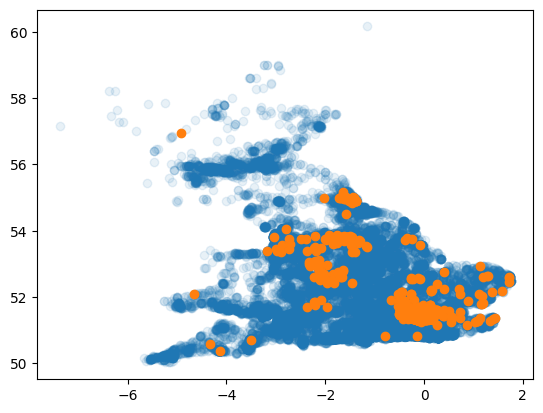

In [66]:
plt.scatter(final_df[final_df.junction_location==8].longitude,final_df[final_df.junction_location==8].latitude,alpha=0.1)
plt.scatter(final_df[final_df.junction_location==-1].longitude,final_df[final_df.junction_location==-1].latitude)


<Axes: >

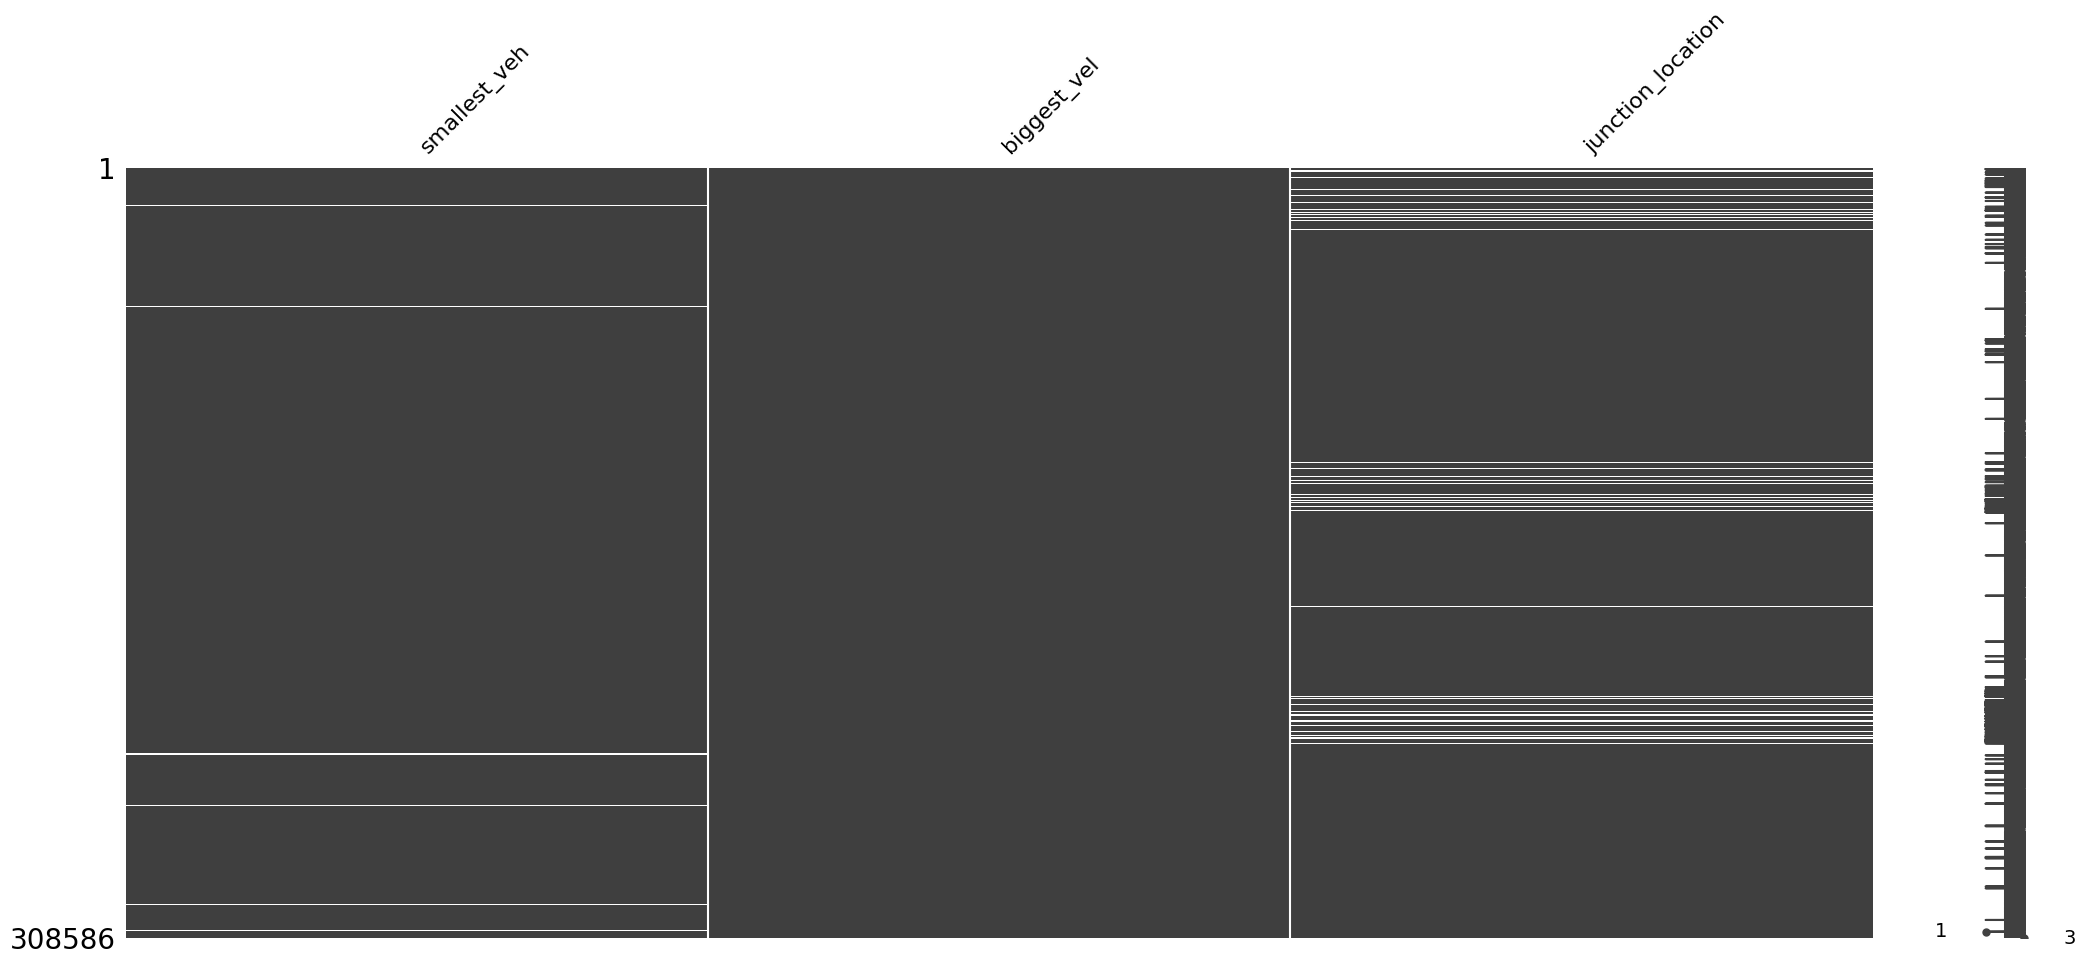

In [67]:
##Drop cases with biggest_vel =-1 as we don't have info on any of the veh_type
#final_df = final_df[final_df['biggest_vel'] != -1]
# Remove instances where 'veh_num' is 1 and 'smallest_veh' is -1
#final_df = final_df[~((final_df['veh_num'] == 1) & (final_df['smallest_veh'] == -1))]

#### remove all instances of -1
final_df.replace(-1, np.nan, inplace=True)
missingdata_df = final_df.columns[final_df.isnull().any()].tolist()
msno.matrix(final_df[missingdata_df])


In [78]:
#print(final_df.uncertainty.value_counts())
final_df[(final_df.uncertainty>=final_df.veh_num)].veh_num.value_counts()
final_df[(final_df.uncertainty>=final_df.veh_num)].accident_severity.value_counts()
final_df[(final_df.uncertainty>=final_df.veh_num)&(final_df.veh_num<2)].accident_severity.value_counts()
final_df[(final_df.uncertainty>=1)].accident_severity.value_counts()

#plt.hist(final_df.uncertainty)

3    8584
2     784
1       5
Name: accident_severity, dtype: int64

In [80]:
min_max_values = final_df.agg(['min','median','max', 'std' ])
min_max_values.T

,min,median,max,std
accident_year,2019.000000,2020.000000,2021.000000,0.837458
longitude,-7.497375,-1.235529,1.757476,1.392365
latitude,49.917760,52.036441,60.541144,1.365357
police_force,1.000000,31.000000,99.000000,24.273103
accident_severity,1.000000,3.000000,3.000000,0.465996
number_of_vehicles,1.000000,2.000000,5.000000,0.683452
number_of_casualties,1.000000,1.000000,5.000000,0.676095
day_of_week,1.000000,4.000000,7.000000,1.932198
first_road_class,1.000000,4.000000,6.000000,1.469023
road_type,1.000000,6.000000,9.000000,1.607707


In [79]:
final_df.dropna(axis=0,inplace=True)
final_df=final_df[final_df.uncertainty==0]   # just get read of all uncertainties
dropcols=['accident_index','accident_reference','veh_num','uncertainty']
final_df = final_df.drop(columns=dropcols)
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 278143 entries, 2 to 308585
Data columns (total 40 columns):
 #   Column                                       Non-Null Count   Dtype  
---  ------                                       --------------   -----  
 0   accident_year                                278143 non-null  int32  
 1   longitude                                    278143 non-null  float64
 2   latitude                                     278143 non-null  float64
 3   police_force                                 278143 non-null  int32  
 4   accident_severity                            278143 non-null  int32  
 5   number_of_vehicles                           278143 non-null  int32  
 6   number_of_casualties                         278143 non-null  int32  
 7   day_of_week                                  278143 non-null  int32  
 8   first_road_class                             278143 non-null  int32  
 9   road_type                                    278143 non-nul

In [82]:
final_df.columns
unit8cols=['police_force',
       'accident_severity', 'number_of_vehicles', 'number_of_casualties',
       'day_of_week', 'first_road_class', 'road_type', 'speed_limit',
       'junction_detail', 'pedestrian_crossing_human_control',
       'pedestrian_crossing_physical_facilities', 'light_conditions',
       'weather_conditions', 'road_surface_conditions',
       'special_conditions_at_site', 'carriageway_hazards',
       'urban_or_rural_area', 'did_police_officer_attend_scene_of_accident',
       'trunk_road_flag', 'hour', 'weekend', 'month', 'covid',
       'accident_level', 'time_of_day', 'smallest_veh', 'biggest_vel',
       'towing', 'restricted', 'junction_location', 'skidding', 'jacknifed',
       'overturned', 'xcenterguard', 'rebounded', 'male_drivers',
       'female_drivers']
final_df[unit8cols] = final_df[unit8cols].astype('uint8')
final_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 278143 entries, 2 to 308585
Data columns (total 40 columns):
 #   Column                                       Non-Null Count   Dtype  
---  ------                                       --------------   -----  
 0   accident_year                                278143 non-null  int32  
 1   longitude                                    278143 non-null  float64
 2   latitude                                     278143 non-null  float64
 3   police_force                                 278143 non-null  uint8  
 4   accident_severity                            278143 non-null  uint8  
 5   number_of_vehicles                           278143 non-null  uint8  
 6   number_of_casualties                         278143 non-null  uint8  
 7   day_of_week                                  278143 non-null  uint8  
 8   first_road_class                             278143 non-null  uint8  
 9   road_type                                    278143 non-nul

In [83]:
#saving the datasets
final_df.to_pickle("./drive/MyDrive/Accidents/Data/acc_veh_cat.pkl")

In [ ]:
#df_cat = pd.read_pickle("./drive/MyDrive/Accidents/Data/acc_veh_cat.pkl")
#df_cat.info()